In this notebook, we will look at historical data of various product's sales by date. Also included in this dataset are the warehouse the product is shipped from and the category for a specific product. The first step is to read in the data.

In [115]:
import numpy as np
import pandas as pd

original = pd.read_csv("../data/Historical Product Demand.csv")
print(original.head(5))

#we can drop the rows that don't have a date- these happen to be the only rows with NaN. It's okay to just drop them because 
#they represent only ~1% of the data set and the associated data is useless without the date
original.dropna(inplace=True)


   Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500 


In [116]:
#change the type of the input data to be accessible by the models

original['Date'] = pd.to_datetime(original['Date']) 
original.sort_values(['Date'], inplace=True)

original['Order_Demand'] = original['Order_Demand'].replace('[(]', '-', regex=True).astype('str')
original['Order_Demand'] = original['Order_Demand'].replace('[)]', '', regex=True).astype('int')   

original = original.groupby(['Date', 'Product_Code', 'Warehouse', 'Product_Category'])['Order_Demand'].sum().reset_index()

original.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand
0,2011-01-08,Product_0965,Whse_A,Category_006,2
1,2011-05-31,Product_1724,Whse_A,Category_003,108
2,2011-06-24,Product_1521,Whse_S,Category_019,92000
3,2011-09-02,Product_1507,Whse_C,Category_019,1250
4,2011-09-27,Product_0608,Whse_C,Category_001,5


In [117]:
#group by product category

byProdCat = original.groupby(['Date', 'Product_Category'])['Order_Demand'].sum().reset_index()
byProdCat.head()

,Date,Product_Category,Order_Demand
0,2011-01-08,Category_006,2
1,2011-05-31,Category_003,108
2,2011-06-24,Category_019,92000
3,2011-09-02,Category_019,1250
4,2011-09-27,Category_001,28


Next we want to do some exploratory analysis on the data. Since the goal is to do a demand forecast, it would be useful to examine the sales over time  by category. However, there are over 2000 products and over 30 categories, so we will just look at two of them. 

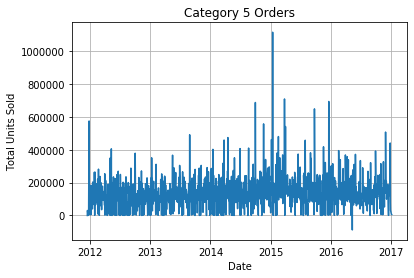

In [118]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

isCat5 = byProdCat['Product_Category'] == 'Category_005'
cat5 = byProdCat[isCat5]
cat5X = cat5['Date']
cat5Y = cat5['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(cat5X, cat5Y)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Category 5 Orders')
ax.grid()
plt.show()

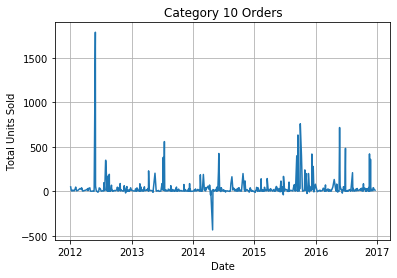

In [119]:
isCat10 = byProdCat['Product_Category'] == 'Category_010'
cat10 = byProdCat[isCat10]
cat10X = cat10['Date']
cat10Y = cat10['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(cat10X, cat10Y)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Category 10 Orders')
ax.grid()
plt.show()

It appears that there is strong fluctation in Category 10, with a severe outlier in 2012. However, category 5 has much more consistent order quantity, with several outliers throughout. A takeaway from these charts is that it could be useful to cut out the extreme outliers, say any data 2 standard deviations away from the mean. However, we won't do that here to remain in the scope of the project time-wise.

What we do need to do is modify the date, as the models can not train with date times. Therefore, we will break the date up into three columns: day, month, and year. Also, we want to include a days since first date. We also need to convert product category, product code, and warehouse to numeric values. We can use regular expressions to change the product category and product codes to ints and label encoding to modify the warehouse values.

In [120]:
import datetime
original['year'] = pd.DatetimeIndex(original['Date']).year
original['month'] = pd.DatetimeIndex(original['Date']).month
original['day'] = pd.DatetimeIndex(original['Date']).day

date = original.iloc[0]['Date']
original['daysSinceFirst'] = (original['Date'] - date).dt.days
original['Product_Code'] = original['Product_Code'].replace('[Product_]', '', regex=True).astype('int') 
original['Product_Category'] = original['Product_Category'].replace('[Category_]', '', regex=True).astype('int')  


from sklearn import preprocessing
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(original['Warehouse'])
original['Warehouse'] = le.transform(original['Warehouse'])

original.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand,year,month,day,daysSinceFirst
0,2011-01-08,965,0,6,2,2011,1,8,0
1,2011-05-31,1724,0,3,108,2011,5,31,143
2,2011-06-24,1521,3,19,92000,2011,6,24,167
3,2011-09-02,1507,1,19,1250,2011,9,2,237
4,2011-09-27,608,1,1,5,2011,9,27,262


Below we will split the data 80/20 into testing and training data. First, we have to separate the Y (Order_Demand) with everything out.

In [121]:
from sklearn.model_selection import train_test_split

Y = original['Order_Demand']
X = original[['year', 'month', 'day', 'daysSinceFirst', 'Product_Category', 'Warehouse', 'Product_Code']]

#80/20 split for train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size = .2)

print("X_test: ")
print(X_train.head())

print("Y_test: ")
print(Y_train.head())

X_test: 
        year  month  day  daysSinceFirst  Product_Category  Warehouse  \
239066  2013     11   29            1056                 7          1   
196078  2013      8    5             940                 1          1   
484689  2015     10    9            1735                24          0   
59632   2012      6   25             534                19          0   
489623  2015     10   23            1749                15          2   

        Product_Code  
239066           202  
196078           610  
484689          1053  
59632            421  
489623           453  
Y_test: 
239066    3000
196078      88
484689      40
59632      300
489623       4
Name: Order_Demand, dtype: int64


Next we will train a basic linear regression model. I don't expect this to do well, however it provides a simple baseline to start.

In [122]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#train model
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [123]:
# Make predictions using the testing set
y_pred_linear = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, y_pred_linear))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, y_pred_linear))
print('Order_Demand average: %.2f' % Y.mean())

Coefficients: 
 [ 1.56602320e+03  9.48066820e+01 -8.81361041e+00 -3.82596270e+00
  3.26241906e+02  3.34894625e+03  2.54427771e+00]
Mean squared error: 2165804114.40
Variance score: 0.01
Order_Demand average: 8043.22


Clearly, a plain linear regression isn't going to work well. We would need to do a linear regression for each product, or potentially each product category, to make it work better. Let's briefly explore that below with category 5, an extension of the visual we did earlier.

In [124]:
byProdCat = original.groupby(['year', 'month', 'day', 'daysSinceFirst', 'Product_Category'])['Order_Demand'].sum().reset_index()
isCat10 = byProdCat['Product_Category'] == 10
cat10 = byProdCat[isCat10]
Y = cat10['Order_Demand']
X = cat10[['year', 'month', 'day', 'daysSinceFirst', 'Product_Category']]

#80/20 split for train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size = .2)

#train model
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
y_pred_linear = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, y_pred_linear))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, y_pred_linear))
print('Order_Demand average: %.2f' % Y.mean())



Coefficients: 
 [4676.96358363  392.18022136   12.84312416  -12.80566839    0.        ]
Mean squared error: 7411.22
Variance score: -0.01
Order_Demand average: 37.78


The variance remains very poor (R^2 value). At 1 it would be a perfect predictor. Let's try a different model.  Now a gradient boosting classifier with several different learning rates.

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, Y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, Y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, Y_test)))
    print(' ')

Learning rate:  0.05
Accuracy score (training): 0.501
Accuracy score (validation): 0.045
 
Learning rate:  0.075
Accuracy score (training): 0.582
Accuracy score (validation): 0.036
 
Learning rate:  0.1
Accuracy score (training): 0.629
Accuracy score (validation): 0.018
 
Learning rate:  0.25
Accuracy score (training): 0.013
Accuracy score (validation): 0.009
 
Learning rate:  0.5
Accuracy score (training): 0.027
Accuracy score (validation): 0.000
 
Learning rate:  0.75
Accuracy score (training): 0.058
Accuracy score (validation): 0.009
 
Learning rate:  1
Accuracy score (training): 0.056
Accuracy score (validation): 0.018
 


Obviously none of these have good performance. The accuracy score (validation) is the primary measure of success - this is the R^2 value, with 1 being optimal. As mentioned earlier, it might be better to predict by product and ignore many of the datasets which are simply impossible to predict (i.e. a single spike or similar). One way to bin these quantitatively is to train a model for each product, then select the best performing ones. However, this is highly inefficient and time consuming. Therefore, we can proxy this by hypothesizing that we will be able to best predict order_demand for products which have a low standard-deviation to mean ratio, also known as the coefficient of variation. In the real world, we'd want to ignore products that have below a certain amount of orders shipped (if they shipped on under 100 days for example, ignore that product). For now, due to the 10-hour rule, we will simply inspect a couple to generate models on.

In [126]:
means = original.groupby(['Product_Code'])['Order_Demand'].mean().reset_index()
stdevs = original.groupby(['Product_Code'])['Order_Demand'].std().reset_index()

ratio = pd.DataFrame(columns=['Product_Code', 'ratio'])
ratio['Product_Code'] = stdevs['Product_Code']
ratio['ratio'] = stdevs['Order_Demand'] / means['Order_Demand']

#sort by ratio
ratio.sort_values(['ratio'], inplace=True)

ratio.head(50)


,Product_Code,ratio
1687,1698,0.000000
1037,1048,0.096328
1306,1317,0.124935
1568,1579,0.134697
2029,2042,0.174331
2031,2044,0.176170
66,67,0.177924
2034,2047,0.193542
1351,1362,0.214270
2035,2048,0.230050


Now that we have the products with the lowest coefficient of variation, let's plot a few of them. We want to find a couple that ship orders on quite a few dates, which we will do by inspection here.

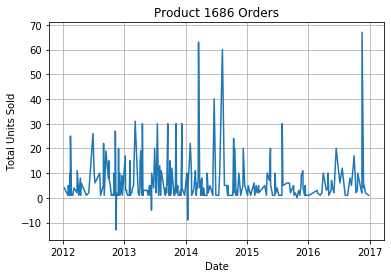

In [127]:
byProd = original.groupby(['Date', 'Product_Code', 'year', 'month', 'day', 'daysSinceFirst'])['Order_Demand'].sum().reset_index()

is1686 = byProd['Product_Code'] == 1686
prod1 = byProd[is1686]
prod1X = prod1['Date']
prod1Y = prod1['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(prod1X, prod1Y)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Product 1686 Orders')
ax.grid()
plt.show()

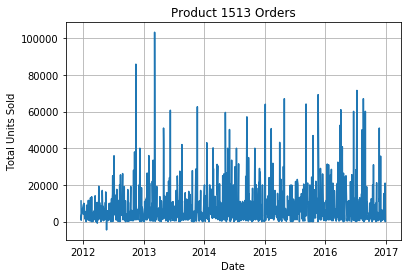

In [128]:
is1513 = byProd['Product_Code'] == 1513
prod2 = byProd[is1513]
prod2X = prod2['Date']
prod2Y = prod2['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(prod2X, prod2Y)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Product 1513 Orders')
ax.grid()
plt.show()

These two only have a few outliers, so we may be able to predict them with higher accuracy. Let's see, using the gradient boosting classifier used earlier.

In [129]:
#prepare data

Y1 = prod1['Order_Demand']
X1 = prod1[['year', 'month', 'day', 'daysSinceFirst']]

#80/20 split for train and test data
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, random_state=1, test_size = .2)

Y2 = prod2['Order_Demand']
X2 = prod2[['year', 'month', 'day', 'daysSinceFirst']]

#80/20 split for train and test data
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, random_state=1, test_size = .2)

In [130]:
#Run it for the first product: Product 1686

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X1_train, Y1_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X1_train, Y1_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X1_test, Y1_test)))
    print(' ')

Learning rate:  0.05
Accuracy score (training): 0.475
Accuracy score (validation): 0.236
 
Learning rate:  0.075
Accuracy score (training): 0.584
Accuracy score (validation): 0.236
 
Learning rate:  0.1
Accuracy score (training): 0.648
Accuracy score (validation): 0.236
 
Learning rate:  0.25
Accuracy score (training): 0.831
Accuracy score (validation): 0.164
 
Learning rate:  0.5
Accuracy score (training): 0.055
Accuracy score (validation): 0.018
 
Learning rate:  0.75
Accuracy score (training): 0.082
Accuracy score (validation): 0.018
 
Learning rate:  1
Accuracy score (training): 0.023
Accuracy score (validation): 0.018
 


In [132]:
#Run it for the second product: Product 1513

lr_list = [0.05, 0.075, 0.1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X2_train, Y2_train)


    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X2_train, Y2_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X2_test, Y2_test)))
    print(' ')

Learning rate:  0.05
Accuracy score (training): 0.496
Accuracy score (validation): 0.046
 
Learning rate:  0.075
Accuracy score (training): 0.371
Accuracy score (validation): 0.021
 
Learning rate:  0.1
Accuracy score (training): 0.166
Accuracy score (validation): 0.021
 


We varied the learning rate on here to see how different parameters affected the outcome. A smaller learning rate, while likely less efficient, led to higher accuracy. The accuracy for product 1686 was much better than all other predictions in this notebook for the .05 learning rate, which goes to support the hypothesis that breaking down the overall problem into predictions for each distinct product will increase accuracy. With a .236 accuracy value, it far outperforms everyting else. One reason it could have outperformed the product 1513 model is because its extreme values were much closer to the mean, as can be seen on the graphs. Due to the 10-hour rule, I won't go further, but the takeaways from this project were to figure out how to get the most value out of a dataset that doesn't necessarily respond well to plugging it in to a regression model from the start. Breaking it down and modifying date features helped, as we showed, but not particularly much by category. Arguably the most important part was identifying products that lacked many outliers, in a way that we could actually predict these. Although we did this mainly by inspection for the sake of time, the discussion that went with that suggested we a method for doing it at scale.